## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [8]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.3]
redice_lr_patient = [5, 10]

In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 3s 62us/step - loss: 1.4267 - accuracy: 0.5012 - val_loss: 1.5614 - val_accuracy: 0.4496
Epoch 11/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.4041 - accuracy: 0.5084 - val_loss: 1.5568 - val_accuracy: 0.4461
Epoch 12/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.3810 - accuracy: 0.5154 - val_loss: 1.5456 - val_accuracy: 0.4525
Epoch 13/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.3601 - accuracy: 0.5247 - val_loss: 1.5327 - val_accuracy: 0.4597
Epoch 14/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.3400 - accuracy: 0.5317 - val_loss: 1.5287 - val_accuracy: 0.4591
Epoch 15/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.3209 - accuracy: 0.5406 - val_loss: 1.5282 - val_accuracy: 0.4642
Epoch 16/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.3013 - accuracy: 0.5459 - val_loss: 1.5200

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 78us/step - loss: 2.3364 - accuracy: 0.2340 - val_loss: 2.1918 - val_accuracy: 0.1917
Epoch 2/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.8513 - accuracy: 0.3555 - val_loss: 2.0202 - val_accuracy: 0.2862
Epoch 3/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.7209 - accuracy: 0.3959 - val_loss: 1.8850 - val_accuracy: 0.3470
Epoch 4/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.6463 - accuracy: 0.4200 - val_loss: 1.7870 - val_accuracy: 0.3750
Epoch 5/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.5930 - accuracy: 0.4384 - val_loss: 1.7149 - val_accuracy: 0.3965
Epoch 6/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.5520 - accuracy: 0.4536 - val_loss: 1.6710 - val_accuracy: 0.4098
Epoch 7/25
50000/50000 [==============================] - 3s 61us/st

50000/50000 [==============================] - 3s 69us/step - loss: 0.5308 - accuracy: 0.8271 - val_loss: 1.7815 - val_accuracy: 0.4691
Epoch 21/25
50000/50000 [==============================] - 4s 73us/step - loss: 0.5090 - accuracy: 0.8338 - val_loss: 1.8589 - val_accuracy: 0.4721
Epoch 22/25
50000/50000 [==============================] - 6s 113us/step - loss: 0.4809 - accuracy: 0.8446 - val_loss: 1.7071 - val_accuracy: 0.4868
Epoch 23/25
50000/50000 [==============================] - 5s 102us/step - loss: 0.4532 - accuracy: 0.8553 - val_loss: 1.8846 - val_accuracy: 0.4745

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 24/25
50000/50000 [==============================] - 4s 89us/step - loss: 0.3741 - accuracy: 0.8920 - val_loss: 1.6757 - val_accuracy: 0.5041
Epoch 25/25
50000/50000 [==============================] - 4s 78us/step - loss: 0.3400 - accuracy: 0.9077 - val_loss: 1.6753 - val_accuracy: 0.5139
Numbers of exp: 5, reduce_factor: 0.50, r

Epoch 4/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.3071 - accuracy: 0.5417 - val_loss: 1.5746 - val_accuracy: 0.4465
Epoch 5/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.2482 - accuracy: 0.5635 - val_loss: 1.5442 - val_accuracy: 0.4472
Epoch 6/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.1928 - accuracy: 0.5844 - val_loss: 1.5033 - val_accuracy: 0.4637
Epoch 7/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.1445 - accuracy: 0.6045 - val_loss: 1.4739 - val_accuracy: 0.4814
Epoch 8/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.1000 - accuracy: 0.6194 - val_loss: 1.4690 - val_accuracy: 0.4832
Epoch 9/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.0600 - accuracy: 0.6345 - val_loss: 1.4951 - val_accuracy: 0.4701
Epoch 10/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.0223 - accuracy: 0.6480 - val_loss: 

50000/50000 [==============================] - 4s 74us/step - loss: 1.2378 - accuracy: 0.5815 - val_loss: 1.5180 - val_accuracy: 0.4734
Epoch 24/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.2285 - accuracy: 0.5832 - val_loss: 1.5167 - val_accuracy: 0.4732
Epoch 25/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.2182 - accuracy: 0.5879 - val_loss: 1.5140 - val_accuracy: 0.4734
Numbers of exp: 8, reduce_factor: 0.50, reduce_patient: 5
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_______________________________

Epoch 7/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.1960 - accuracy: 0.5841 - val_loss: 1.9470 - val_accuracy: 0.3721
Epoch 8/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.1544 - accuracy: 0.5991 - val_loss: 1.6165 - val_accuracy: 0.4417
Epoch 9/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.1138 - accuracy: 0.6132 - val_loss: 1.8182 - val_accuracy: 0.4040
Epoch 10/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.0726 - accuracy: 0.6297 - val_loss: 1.9797 - val_accuracy: 0.3625
Epoch 11/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.0415 - accuracy: 0.6400 - val_loss: 2.0770 - val_accuracy: 0.3619
Epoch 12/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.0125 - accuracy: 0.6511 - val_loss: 1.7657 - val_accuracy: 0.4014
Epoch 13/25
50000/50000 [==============================] - 4s 81us/step - loss: 0.9750 - accuracy: 0.6656 - val_los

50000/50000 [==============================] - 3s 61us/step - loss: 0.7855 - accuracy: 0.7560 - val_loss: 1.4035 - val_accuracy: 0.5203
Numbers of exp: 11, reduce_factor: 0.30, reduce_patient: 10
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_34 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_35 (Batc (None, 256)               1024      
____________________________________________________________

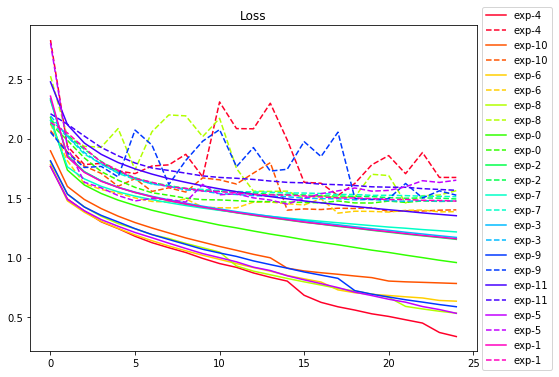

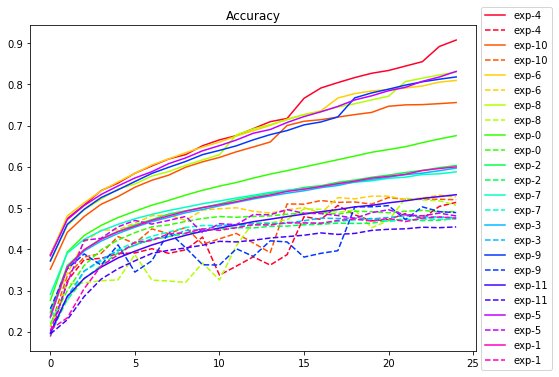

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()